## Explicit treatment of viscous term

In this test case, which is $ \theta=0$, cannot be directly established from the main code notebook, as the 2nd step goes fully explicit. In this code notebook, the 1st step has the same schemes with the main project notebook, where 2nd step has new explicit treatment.

The discretization now yields:

Step 1:

velocity u

\begin{equation}
-(\frac{1}{2}\Delta t \delta u^n_{i,j})u^\ast_{i-1,j} + (\frac{1}{2} \Delta t \delta u^n_{i,j}) u^\ast_{i+1,j} + (\delta^2)u^\ast_{i,j} - (\frac{1}{2}\Delta t \delta v^n_{i,j}) u^\ast_{i,j-1} + (\frac{1}{2} \Delta t \delta v^n_{i,j}) u^\ast_{i,j+1}\\
= (\delta^2 - 4 \Delta t \nu)u^n_{i,j} + \Delta t \nu (u^n_{i-1,j}+u^n_{i+1,j}+u^n_{i,j-1}+u^n_{i,j+1})
\end{equation}

The same coefficients go for velocity v.

Step 2:

pressure $p^{n+1}$

\begin{equation}
\nabla^2 p^{n+1}_{i,j} = \frac{u^\ast_{i+1,j}-u^\ast_{i-1,j} + v^\ast_{i,j+1}-v^\ast_{i,j-1}}{2\Delta t \delta}
\end{equation}

velocity u

\begin{equation}
u^{n+1}_{i,j}=u^\ast_{i,j}-\frac{\Delta t}{2\delta} (p^{n+1}_{i+1,j}-p^{n+1}_{i-1,j})
\end{equation}

velocity v

\begin{equation}
v^{n+1}_{i,j}=v^\ast_{i,j}-\frac{\Delta t}{2\delta} (p^{n+1}_{i,j+1}-p^{n+1}_{i,j-1})
\end{equation}

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
%matplotlib inline

from laplace_helper import L2_rel_error
import sys

In [2]:
xmin = 0; xmax = 10
ymin = 0; ymax = 10
nx = 41
ny = 41

l2_target = 1e-5

T = 1
dt = 0.001
nt = int(T/dt+1)

In [3]:
dx = (xmax-xmin)/(nx-1)
dy = (ymax-ymin)/(ny-1)
dh = dx # dh=dx=dy in this method

# Mesh
x  = np.linspace(xmin,xmax,nx)
y  = np.linspace(ymin,ymax,ny)
X,Y = np.meshgrid(x,y)

In [4]:
def construct_Matrix_u_step1(nx, ny, u, v):
    """ Construct matrix of implicit scheme of u for step 1

    Returns:
    -------
    A_u: 2D array of floats
        Matrix A in linear system of u for step 1
    """
    A_u = np.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif i==nx-2 and j==1: # Bottom right corner
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]    # Fetch i-1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif i==1 and j==ny-2: # Top left corner
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]       # fetch i+1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i]   # fetch j-1
                
            elif i==nx-2 and j==ny-2: # Top right corner
                A_u[row_number,row_number] = dh**2   # Set diagonal
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]       # Fetch i-1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i]   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
            
            elif i==nx-2: # Right boundary (Dirichlet)
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]     # fetch i+1
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i] # fetch j+1
                
            elif j==ny-2: # Top boundary (Dirichlet)
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]       # fetch i-1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                
            # Interior points
            else:
                A_u[row_number,row_number] = dh**2 # Set diagonal
                A_u[row_number,row_number+1] = 1/2*dt*dh*u[j,i]     # fetch i+1
                A_u[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_u[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_u[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A_u

In [5]:
def construct_Matrix_v_step1(nx, ny, u, v):
    """ Construct matrix of implicit scheme of v for step 1

    Returns:
    -------
    A_v: 2D array of floats
        Matrix A in linear system of v for step 1
    """
    A_v = np.zeros(((nx-2)*(ny-2),(nx-2)*(ny-2)))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]     # fetch i+1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif i==nx-2 and j==1: # Bottom right corner
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # Fetch i-1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif i==1 and j==ny-2: # Top left corner
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i]   # fetch j-1
                
            elif i==nx-2 and j==ny-2: # Top right corner
                A_v[row_number,row_number] = dh**2   # Set diagonal
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]       # Fetch i-1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i]   # fetch j-1
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]     # fetch i+1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
            
            elif i==nx-2: # Right boundary (Dirichlet)
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]    # fetch i-1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif j==1: # Bottom boundary (Dirichlet)
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]   # fetch j+1
                
            elif j==ny-2: # Top boundary (Dirichlet)
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                
            # Interior points
            else:
                A_v[row_number,row_number] = dh**2 # Set diagonal
                A_v[row_number,row_number+1] = 1/2*dt*dh*u[j,i]      # fetch i+1
                A_v[row_number,row_number-1] = -1/2*dt*dh*u[j,i]     # fetch i-1
                A_v[row_number,row_number-(nx-2)] = -1/2*dt*dh*v[j,i] # fetch j-1
                A_v[row_number,row_number+nx-2] = 1/2*dt*dh*v[j,i]    # fetch j+1
                
            row_number += 1 # Jump to next row of the matrix!
    
    return A_v

In [6]:
def generate_RHS_u_step1(nx, ny, u, v):
    """ Construct RHS of implicit scheme of u for step 1

    Returns:
    -------
    RHS_u: 1D array of floats
        RHS in linear system of u for step 1
    """
    RHS_u = np.zeros((nx-2)*(ny-2))
    u_lid = 1
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            # Corners
            if i==1 and j==1: # Bottom left corner
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
                
            elif i==nx-2 and j==1: # Bottom right corner 
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
                           
            elif i==1 and j==ny-2: # Top left corner
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i]) \
                - (1/2*dt*dh*u[j,i])*u_lid
                
            elif i==nx-2 and j==ny-2: # Top right corner
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i]) \
                - (1/2*dt*dh*u[j,i])*u_lid
              
            # Sides
            elif i==1: # Left boundary (Dirichlet)
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
            
            elif i==nx-2: # Right boundary (Dirichlet)
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
                
            elif j==1: # Bottom boundary (Dirichlet)
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
                
            elif j==ny-2: # Top boundary (Dirichlet)
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i]) \
                - (1/2*dt*dh*u[j,i])*u_lid
                
            # Interior points
            else:
                RHS_u[row_number] = (dh**2-4*dt*nu)*u[j,i] + dt*nu*(u[j,i-1]+u[j,i+1]+u[j-1,i]+u[j+1,i])
                
            row_number += 1 # Jump to next row!
    
    return RHS_u

In [7]:
def generate_RHS_v_step1(nx, ny, u, v):
    """ Construct RHS of implicit scheme of v for step 1

    Returns:
    -------
    RHS_v: 1D array of floats
        RHS in linear system of v for step 1
    """
    RHS_v = np.zeros((nx-2)*(ny-2))
    
    row_number = 0 # row counter
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            
            RHS_v[row_number] = (dh**2-4*dt*nu)*v[j,i] + dt*nu*(v[j,i-1]+v[j,i+1]+v[j-1,i]+v[j+1,i])

            row_number += 1 # Jump to next row!
    
    return RHS_v

In [8]:
def solve_Poisson(p, b, dx, dy, l2_target):    
    """ Solve Poisson equation for pressure in step 2

    Returns:
    -------
    p: 2D array of floats
        Pressure at time step (n+1)
    """
    # Initialize
    p = np.zeros((ny,nx))
    
    l2_norm = 1
    iterations = 0
    l2_conv = []
    
    # Solve
    while l2_norm > l2_target:

        pd = p.copy()

        p[1:-1,1:-1] = 1/(2*(dx**2 + dy**2)) * \
                        ((pd[1:-1,2:]+pd[1:-1,:-2])*dy**2 +\
                        (pd[2:,1:-1] + pd[:-2,1:-1])*dx**2 -\
                         b[1:-1,1:-1]*dx**2*dy**2)
        
        # no BCs needed for pressure in this method
        
        # artificial Neumann BC?
        #p[:, -1] = p[:, -2]        
        #p[0, :] = p[1, :]  
        #p[:, 0] = p[:, 1]   
        #p[-1,:] = p[-2,:]
        
        l2_norm = L2_rel_error(pd,p)
        #iterations += 1
        l2_conv.append(l2_norm)

    return p

In [9]:
def generate_RHS_Poisson(nx, ny):
    """ Construct RHS for pressure Poisson equation
    Valid for nx=ny

    Returns:
    -------
    b_p: 1D array of floats
        RHS for pressure Poisson equation
    """
    
    if nx!=ny:
        print("This method is only valid for nx=ny.")
        sys.exit() # stop running if nx is not equal to ny
    
    b_p = np.zeros((ny,nx))
    b_p[1:-1,1:-1] = (u_star[1:-1,2:] - u_star[1:-1,:-2] + v_star[2:,1:-1] - v_star[:-2,1:-1])/(2*dt*dh)

    return b_p

In [10]:
def step2_explicit(nx, ny, u_star, v_star, p):

    u_plus = np.zeros((ny, nx))
    v_plus = np.zeros((ny, nx))
    
    u_plus[:,1:-1] = u_star[:,1:-1] - dt/(2*dh)*(p[:,2:]-p[:,:-2])
    v_plus[1:-1,:] = v_star[1:-1,:] - dt/(2*dh)*(p[2:,:]-p[:-2,:])
  
    # Enforce BCs
    v_plus[0,:] = 0
    v_plus[-1,:] = 0
    v_plus[:,0] = 0
    v_plus[:,-1] = 0
    
    u_plus[0,:] = 0
    u_plus[-1,:] = 1
    u_plus[:,0] = 0
    u_plus[:,-1] = 0
        
    return u_plus, v_plus

In [11]:
def map_u_1Dto2D(nx, ny, u_1D):
    """ Take solution of u from linear system, stored in 1D, 
    and put them in a 2D array with the BCs.
  
    Returns:
    -------
        u: 2D array of float
            u stored in 2D array with BCs
    """
    u = np.zeros((ny,nx))
    
    row_number = 0
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            u[i,j] = u_1D[row_number]
            row_number += 1
    # Dirichlet BC
    u[0,:] = 0
    u[:,0] = 0
    u[-1,:] = 1
    u[:,-1] = 0
    
    return u   

In [12]:
def map_v_1Dto2D(nx, ny, v_1D):
    """ Take solution of v from linear system, stored in 1D, 
    and put them in a 2D array with the BCs.
  
    Returns:
    -------
        v: 2D array of float
            v stored in 2D array with BCs
    """
    v = np.zeros((ny,nx))
    
    row_number = 0
    for j in range(1,ny-1):
        for i in range(1,nx-1):
            v[i,j] = v_1D[row_number]
            row_number += 1
    # Dirichlet BC
    v[0,:] = 0
    v[:,0] = 0
    v[-1,:] = 0
    v[:,-1] = 0
    
    return v

In [13]:
# Define calculating parameters
#theta=0
nu=10

# Initialization
u = np.zeros((ny,nx))
#u[-1,:] = 1
v = np.zeros((ny,nx))
p = np.zeros((ny,nx))

In [14]:
for t in range(nt):
    
    # step 1
    
    # solve for u_star
    un = u.copy()
    vn = v.copy()
    A_u = construct_Matrix_u_step1(nx, ny, un, vn)
    b_u = generate_RHS_u_step1(nx, ny, un, vn)
    u_interior = np.linalg.solve(A_u,b_u)
    u_star = map_u_1Dto2D(nx, ny, u_interior)

    # solve for v_star
    A_v = construct_Matrix_v_step1(nx, ny, un, vn)
    b_v = generate_RHS_v_step1(nx, ny, un, vn)
    v_interior = np.linalg.solve(A_v,b_v)
    v_star = map_v_1Dto2D(nx, ny, v_interior)
    
    # step 2
    
    # solve p
    p_plus = p.copy()
    b_p = generate_RHS_Poisson(nx, ny)   
    p = solve_Poisson(p_plus, b_p, dx, dy, l2_target)
    
    # solve for u_n+1
    ustar = u_star.copy()
    vstar = v_star.copy()
    u_plus, v_plus = step2_explicit(nx, ny, ustar, vstar, p)
    
    u = u_plus
    v = v_plus


/Users/cino/Documents/Python/MAE-6286/Project_Qi_Zeng/laplace_helper.py:17: RuntimeWarning: invalid value encountered in double_scalars
  return numpy.sqrt(numpy.sum((p - pn)**2)/numpy.sum(pn**2))


### Results

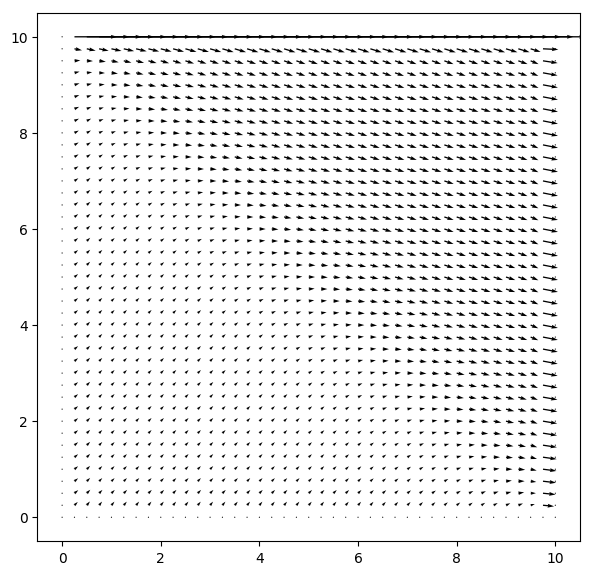

In [15]:
fig = plt.figure(figsize = (7,7), dpi=100)
plt.quiver(X, Y, u, v);

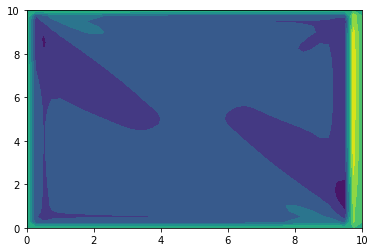

In [16]:
#plt.streamplot(X, Y, u, v, density=2, linewidth=1, arrowsize=1, arrowstyle='->')
plt.contourf(X,Y,p)

You can see the results don't blow up this time. They are much more physical and reasonable. Actually, looking at this velocity result, I think it's obvious the right boundary has some problem. If this boundary has correct value as a "wall", the big vortex will be correct, according to the trends of the velocity here. 

Also, the pressure contour shows the right boundary has some issue making the results incorrect. However, the codes related to the boundary don't have any bugs and represent the method correctly. So now one thing I doubt may be wrong is the pressure Poisson equation's boundary conditions. The original paper states no BCs are needed using this specific method. But by setting $\theta = 0$, it may be different from the original method.

I then tried to apply the artificial Neumann BCs for pressure Poison equation, which is frequently used in fractional time step method. However, most of the time with artificial BCs, the calculation of Poisson equation takes so long (more than one hour) and won't converge well. In other cases, it will give similar results.